In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot

### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=0.)
vW = Parameter("vW", 1, lb=lb, ub=0.)
dW = Parameter("dW", 1, lb=lb, ub=0.)
hW = Parameter("hW", 1, lb=lb, ub=0.)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit", parameters)

In [3]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
print(_lb)
print(_ub)

[-5. -5. -5. -5.]
[0. 0. 0. 0.]


In [4]:
import tensorflow as tf
DTYPE = tf.float32

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

fac = 0.5
# input parameters
E_constant = fac*1.5
E_Pbias = fac*1.
E_Prule = fac*1.2
E_Arule = fac*1.2
E_choice = fac*0.5
E_light = fac*1.
        
# set constant parameters
C = 2

theta = 0.05
beta = 0.5
tau = 0.09
sigma = 0.2

# inputs
I_constant = E_constant * tf.ones((T, 1, 1, 4, 1), dtype=DTYPE)

I_Pbias = np.zeros((T, 4))
I_Pbias[t < T * dt] = np.array([1, 0, 0, 1])
I_Pbias = I_Pbias[:,None,None,:,None]
I_Pbias = E_Pbias * tf.constant(I_Pbias, dtype=DTYPE)

I_Prule = np.zeros((T, 4))
I_Prule[t < 1.2] = np.array([1, 0, 0, 1])
I_Prule = I_Prule[:,None,None,:,None]
I_Prule = E_Prule * tf.constant(I_Prule, dtype=DTYPE)

I_Arule = np.zeros((T, 4))
I_Arule[t < 1.2] = np.array([0, 1, 1, 0])
I_Arule = I_Arule[:,None,None,:,None]
I_Arule = E_Arule * tf.constant(I_Arule, dtype=DTYPE)

I_choice = np.zeros((T, 4))
I_choice[t > 1.2] = np.array([1, 1, 1, 1])
I_choice = I_choice[:,None,None,:,None]
I_choice = E_choice * tf.constant(I_choice, dtype=DTYPE)

I_lightL = np.zeros((T, 4))
#I_lightL[1.2 < t] = np.array([1, 1, 0, 0])
I_lightL[np.logical_and(1.2 < t, t < 1.5)] = np.array([1, 1, 0, 0])
I_lightL = I_lightL[:,None,None,:,None]
I_lightL = E_light * tf.constant(I_lightL, dtype=DTYPE)

I_lightR = np.zeros((T, 4))
#I_lightR[1.2 < t] = np.array([0, 0, 1, 1])
I_lightR[np.logical_and(1.2 < t, t < 1.5)] = np.array([0, 0, 1, 1])
I_lightR = I_lightR[:,None,None,:,None]
I_lightR = E_light * tf.constant(I_lightR, dtype=DTYPE)

I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL

I = tf.concat((I_LP, I_LA), axis=2)


def SC_sim(sW, vW, dW, hW):
    N = 50
    Wrow1 = tf.stack([sW, vW, dW, hW], axis=2)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=2)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=2)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,1
    state_shape = (sW.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    v_t_list = [v]
    u_t_list = [u]
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        #du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * w[i])
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        v_t_list.append(v)
        u_t_list.append(u)

    u_t = tf.stack(u_t_list, axis=0)
    v_t = tf.stack(v_t_list, axis=0)
    return u_t, v_t

def SC_sim_wrap(z):
    sW = z[:,0][:,None]
    vW = z[:,1][:,None]
    dW = z[:,2][:,None]
    hW = z[:,3][:,None]
    return SC_sim(sW, vW, dW, hW)
    

def SC_acc(sW, vW, dW, hW):
    N = 200
    Wrow1 = tf.stack([sW, vW, dW, hW], axis=2)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=2)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=2)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,N
    state_shape = (sW.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)

    p = tf.reduce_mean(tf.math.sigmoid(100.*(v[:,:,0,:]-v[:,:,3,:])), axis=2)
    return p


(75, 1, 2, 4, 50) 0 0 0
(75, 1, 2, 4, 50) 0 0 1
(75, 1, 2, 4, 50) 0 0 2
(75, 1, 2, 4, 50) 0 0 3
(75, 1, 2, 4, 50) 0 1 0
(75, 1, 2, 4, 50) 0 1 1
(75, 1, 2, 4, 50) 0 1 2
(75, 1, 2, 4, 50) 0 1 3


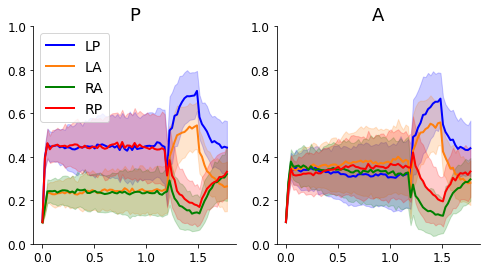

In [5]:
z = np.array([[-1.7, -0.2567, 0.22, -2.43]], dtype=np.float32)
#z = np.zeros((1,4), dtype=np.float32)

u_t, v_t = SC_sim_wrap(z)

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A']
for m in range(1):
    fig, axs = plt.subplots(1,2,figsize=(8, 4))
    for c in range(2):
        for i in range(4):
            print(v_t.shape, m,c,i)
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
    axs[0].legend()
    plt.show()


### 2. Define eps function using Euler

In [6]:
model.set_eps(SC_acc)

def accept_inds(T_x, means, stds):
    acc = np.array([np.logical_and(means[i] - 2*stds[i] < T_x[:,i], 
                    T_x[:,i] < means[i] + 2*stds[i]) for i in range(len(means))])
    return np.logical_and.reduce(acc, axis=0)
                          

In [7]:
num_keep = 100
M = 1000
zs = []
T_xs = []

p = .75
means = [p, 1-p]
stds = [0.025, 0.025]

num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()
    #if z is None:
    #    plt.scatter(_T_x[:,0], 1-_T_x[:,1])
    #    plt.plot([0,1], [0,1], 'k-')
    #    plt.xlabel(r'$p_P$')
    #    plt.ylabel(r'$p_A$')
    #    break

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20
z_labels = [r"$sW_P$",  r"$sW_A$",  r"$vW_{PA}$", r"$vW_{AP}$", 
            r"$dW_{PA}$", r"$dW_{AP}$", r"$hW_P$",  r"$hW_A$"]


In [20]:
print(z_star)

[[-0.6296539 -4.8283634 -1.1942252 -1.2156428]]


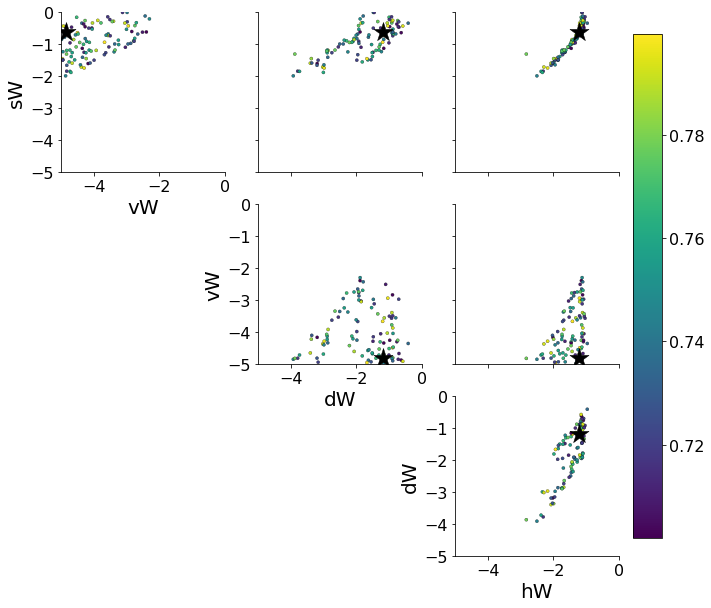

In [14]:
z_labels = [p.name for p in model.parameters]
#z_star = np.mean(z, axis=0)[None,:]
z_star = z[0,:][None,:]

fig = pairplot(z[:num_plot], np.arange(4), z_labels,
               fontsize=fontsize, figsize=(10,10), starred=z_star,
               lb=_lb, ub=_ub, c = T_x[:,0])

z [-0.6296539 -4.8283634 -1.1942252 -1.2156428]


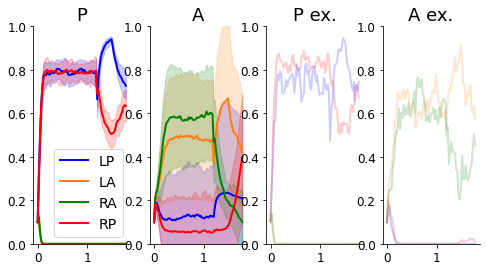

z [-0.49361056 -4.0557075  -1.2563521  -1.0639268 ]


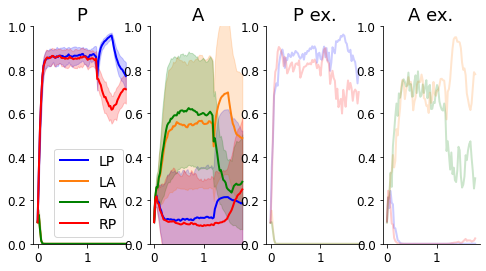

z [-0.6395477 -4.4924283 -0.8919579 -1.1875046]


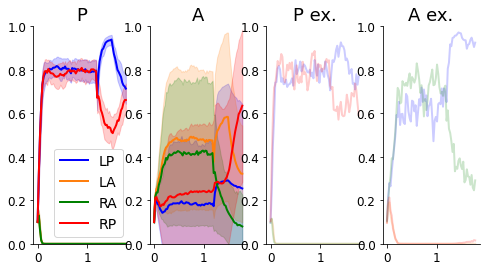

z [-1.5538206 -4.7477164 -1.816041  -1.9772682]


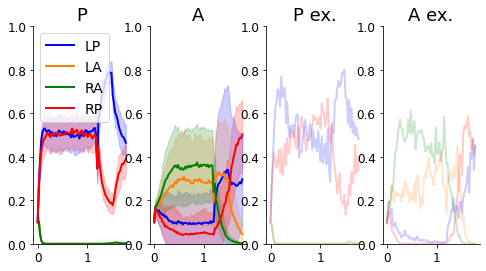

z [-0.9465165 -4.42577   -2.207251  -1.4540259]


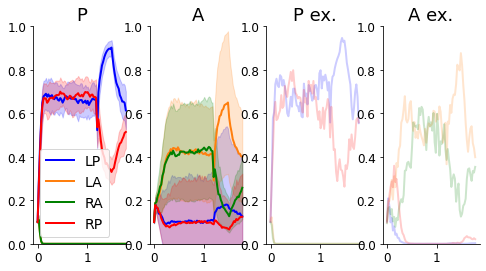

z [-0.85496664 -4.60982    -2.063159   -1.4235326 ]


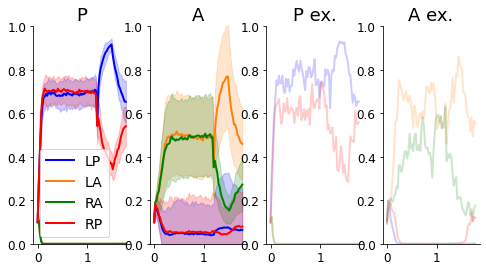

z [-1.0115709 -3.2384324 -1.5334219 -1.4811218]


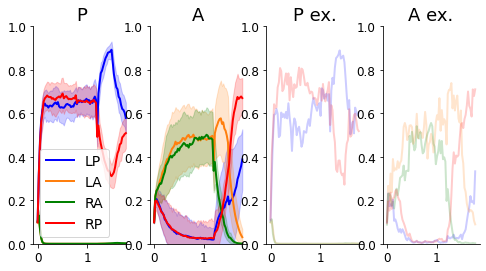

z [-0.3403689 -3.0506442 -1.8486894 -1.1941141]


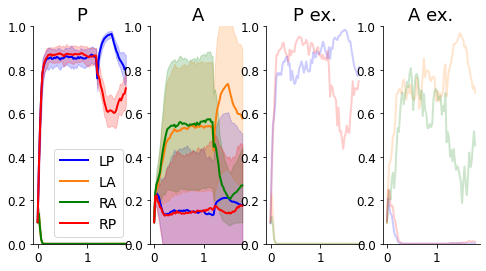

z [-0.11865432 -2.4312844  -1.7867682  -1.1005663 ]


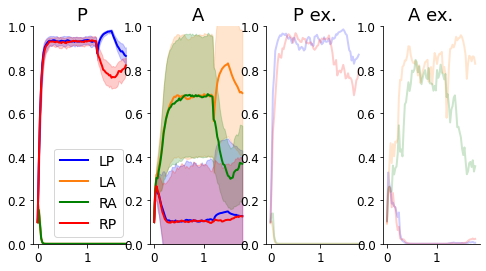

z [-1.486565  -4.933763  -1.5479817 -1.8410726]


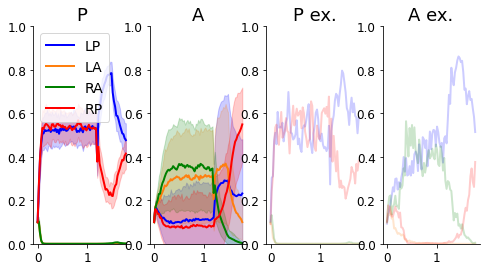

In [15]:
u_t, v_t = SC_sim_wrap(z)

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A']
for m in range(10):
    fig, axs = plt.subplots(1,4,figsize=(8, 4))
    print('z', z[m])
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
            axs[c+2].plot(t, v_t[:,m,c,i,0], color=colors[i], alpha=0.2)
            axs[c+2].set_ylim([0,1])
            axs[c+2].set_title(C_titles[c] + ' ex.')
    axs[0].legend()
    plt.show()


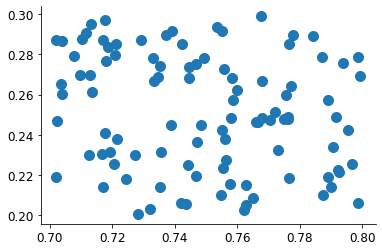

In [16]:
plt.scatter(T_x[:,0], T_x[:,1])

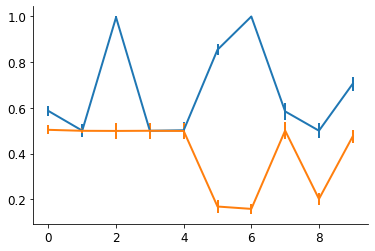

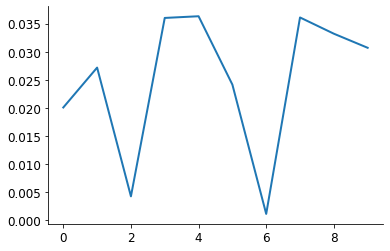

In [19]:
M_interp = 10
z_rand = np.array([np.random.normal(z_star[0,i], 1., (M_interp,)) for i in range(4)], dtype=np.float32).T
T_x_rands = []
N_samp = 250
for i in range(N_samp):
    T_x_rands.append(model.eps(z_rand))
    
T_x_rands = np.stack(T_x_rands, axis=0)
p_mean = np.mean(T_x_rands, axis=0)
p_std = np.std(T_x_rands, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,1], p_std[:,1])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()


In [106]:
T_x_star = model.eps(z_star)
print(T_x_star)

M_interp = 50
z_interp = np.array([np.linspace(0., z_star[0,i], M_interp) for i in range(4)], dtype=np.float32).T

tf.Tensor([[0.9965279  0.01305532]], shape=(1, 2), dtype=float32)


In [107]:
T_x_interps = []
N_samp = 250
for i in range(N_samp):
    T_x_interps.append(model.eps(z_interp))
    
T_x_interps = np.stack(T_x_interps, axis=0)
print(T_x_interps.shape)

(250, 50, 2)


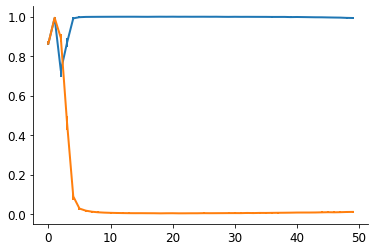

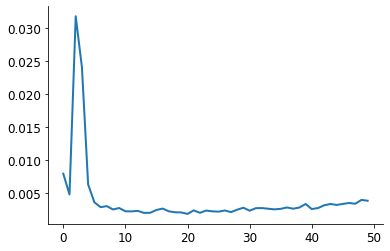

In [108]:
p_mean = np.mean(T_x_interps, axis=0)
p_std = np.std(T_x_interps, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,1], p_std[:,1])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()